In [59]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import train_test_split
import pydotplus
from sklearn import tree
from IPython.display import Image
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.model_selection import cross_val_score

import scikitplot as skplt 

In [2]:
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

In [84]:
df = pd.read_csv('trainingDataAfterDataUnderstanding.csv')

In [85]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8143 entries, 0 to 8142
Data columns (total 6 columns):
Temperature    8143 non-null float64
Humidity       8143 non-null float64
Light          8143 non-null float64
CO2            8143 non-null float64
Occupancy      8143 non-null int64
Weekend        8143 non-null object
dtypes: float64(4), int64(1), object(1)
memory usage: 381.8+ KB


In [5]:
label_encoders = dict()
column2encode = ['Weekend']

for col in column2encode:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

In [6]:
attributes = [col for col in df.columns if col != 'Occupancy']

In [7]:
X = df.drop('Occupancy',axis=1)
y = df['Occupancy']

In [8]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.3, random_state=42)

In [9]:
train_data = pd.concat([X_train, y_train], axis=1)

# Random Search

In [10]:
param_list = {
              'max_depth': [2, 3, 4, 5, 10, 20],
              'min_samples_split': [2, 5, 10, 15, 20, 30, 50, 100],
              'min_samples_leaf': [1, 5, 10, 15, 20, 30, 50, 100],
              'criterion': ['gini', 'entropy'],
             }

In [11]:
Rclf = DecisionTreeClassifier()

random_search = RandomizedSearchCV(Rclf, param_distributions=param_list, n_iter=100)
random_search.fit(X_train, y_train)
report(random_search.cv_results_, n_top=3)

Model with rank: 1
Mean validation score: 0.990 (std: 0.002)
Parameters: {'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': 5, 'criterion': 'gini'}

Model with rank: 2
Mean validation score: 0.990 (std: 0.002)
Parameters: {'min_samples_split': 15, 'min_samples_leaf': 1, 'max_depth': 20, 'criterion': 'entropy'}

Model with rank: 3
Mean validation score: 0.989 (std: 0.001)
Parameters: {'min_samples_split': 20, 'min_samples_leaf': 10, 'max_depth': 10, 'criterion': 'entropy'}



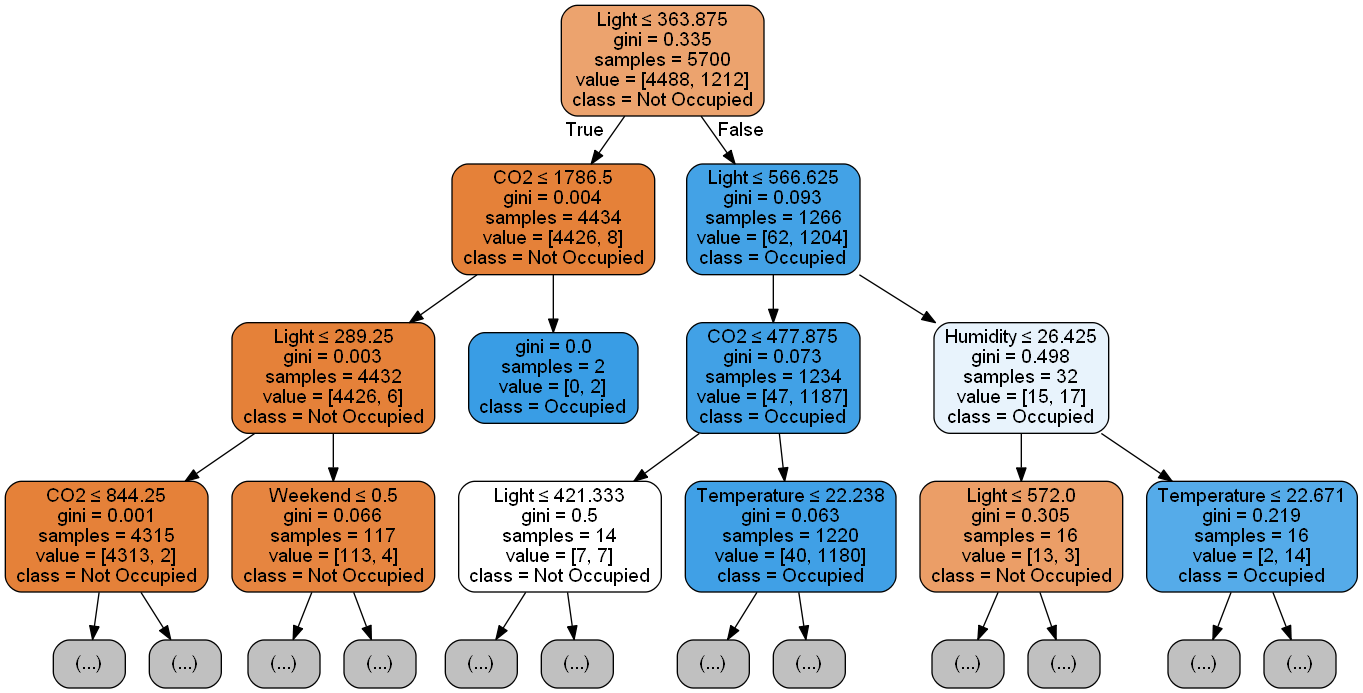

In [27]:
Rclfestimator=random_search.best_estimator_

dot_data = tree.export_graphviz(Rclfestimator, out_file=None,
                                feature_names=attributes,
                                class_names=['Occupied' if x == 1 else 'Not Occupied' for x in Rclfestimator.classes_],  
                                filled=True, rounded=True,  
                                special_characters=True,
                                max_depth=3)  
graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png())

In [13]:
y_pred = Rclfestimator.predict(X_test)
y_pred_tr = Rclfestimator.predict(X_train)
print('Train Accuracy %s' % accuracy_score(y_train, y_pred_tr))
print('Train F1-score %s' % f1_score(y_train, y_pred_tr, average=None))
print()

print('Test Accuracy %s' % accuracy_score(y_test, y_pred))
print('Test F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))
cm=confusion_matrix(y_test, y_pred)
cm

Train Accuracy 0.9931578947368421
Train F1-score [0.99565653 0.98389095]

Test Accuracy 0.9918133442488744
Test F1-score [0.99480789 0.98065764]
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1926
           1       0.98      0.98      0.98       517

    accuracy                           0.99      2443
   macro avg       0.99      0.99      0.99      2443
weighted avg       0.99      0.99      0.99      2443



array([[1916,   10],
       [  10,  507]], dtype=int64)

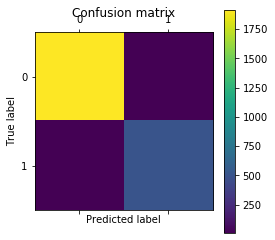

In [14]:
plt.matshow(cm)
plt.title('Confusion matrix')
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [17]:
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
print(roc_auc)

roc_auc = roc_auc_score(y_test, y_pred, average=None)
roc_auc

0.987732766118131


0.987732766118131

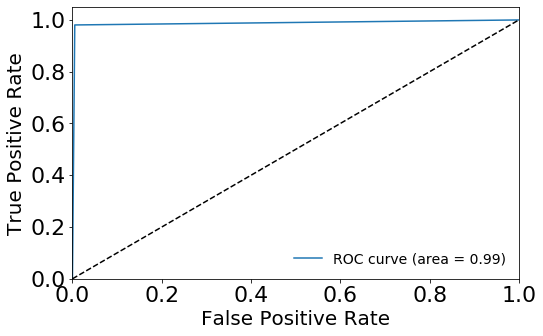

In [18]:
plt.figure(figsize=(8, 5))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % (roc_auc))
    
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=20)
plt.ylabel('True Positive Rate', fontsize=20) 
plt.tick_params(axis='both', which='major', labelsize=22)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.show()

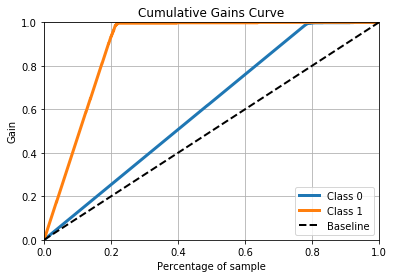

In [108]:
predicted_probas = Rclfestimator.predict_proba(X_test)
skplt.metrics.plot_cumulative_gain(y_test, predicted_probas)
plt.show()

# Grid Search

In [44]:
param_list = {
              'max_depth': [None] + list(np.arange(2, 20)),
              'min_samples_split': [2, 5, 10, 15, 20, 30, 50, 100],
              'min_samples_leaf': [1, 5, 10, 15, 20, 30, 50, 100],
              'criterion': ['gini', 'entropy'],
             }

In [45]:
Gclf = DecisionTreeClassifier()

grid_search = GridSearchCV(Gclf, param_grid=param_list)
grid_search.fit(X_train, y_train)
report(grid_search.cv_results_, n_top=3)

Model with rank: 1
Mean validation score: 0.991 (std: 0.001)
Parameters: {'criterion': 'entropy', 'max_depth': 6, 'min_samples_leaf': 1, 'min_samples_split': 5}

Model with rank: 2
Mean validation score: 0.991 (std: 0.001)
Parameters: {'criterion': 'gini', 'max_depth': 7, 'min_samples_leaf': 1, 'min_samples_split': 10}

Model with rank: 2
Mean validation score: 0.991 (std: 0.001)
Parameters: {'criterion': 'entropy', 'max_depth': 6, 'min_samples_leaf': 1, 'min_samples_split': 2}



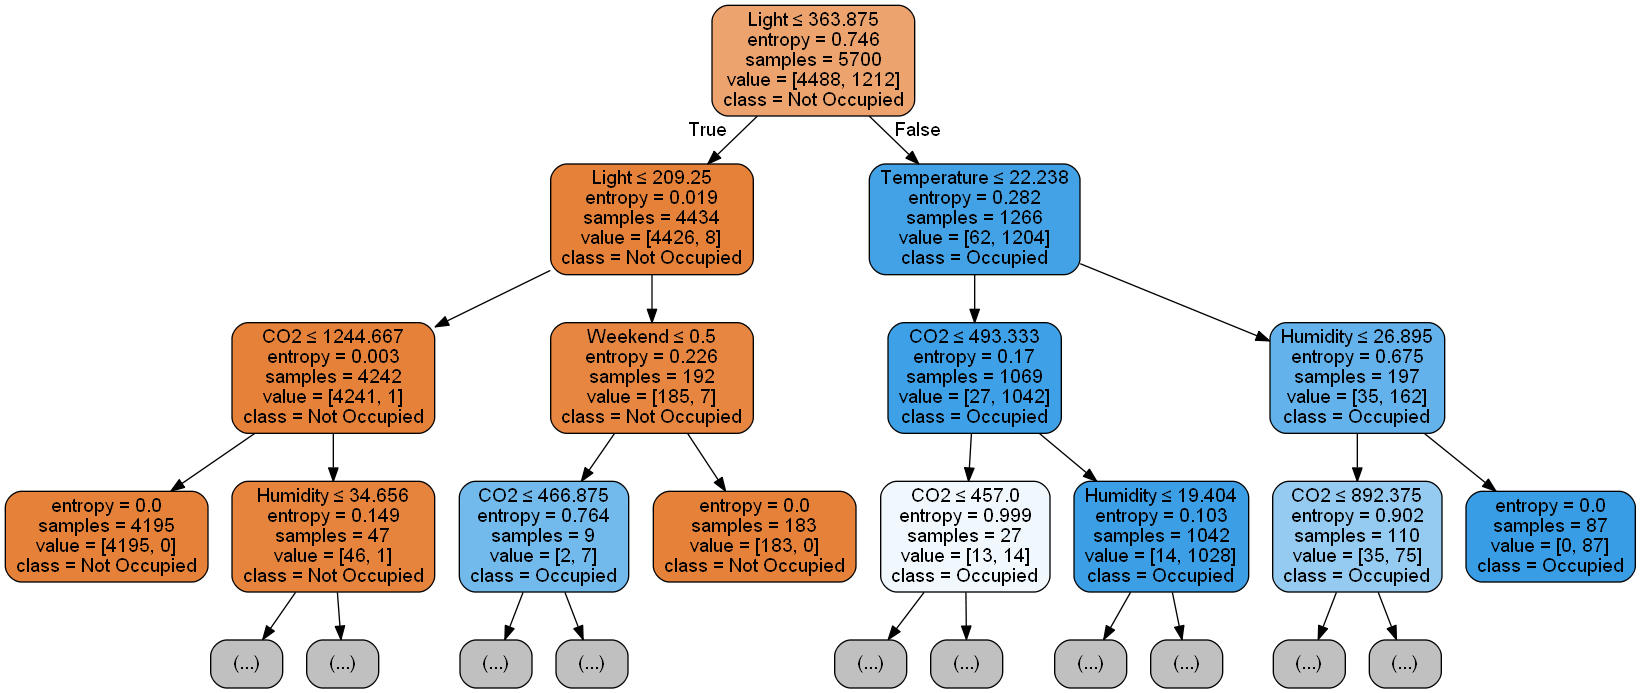

In [96]:
Gclfestimator=grid_search.best_estimator_

dot_data = tree.export_graphviz(Gclfestimator, out_file=None,
                                feature_names=attributes,
                                class_names=['Occupied' if x == 1 else 'Not Occupied' for x in Gclfestimator.classes_],  
                                filled=True, rounded=True,  
                                special_characters=True,
                                max_depth=3)  
graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png())

In [97]:
y_pred = Gclfestimator.predict(X_test)
y_pred_tr = Gclfestimator.predict(X_train)
print('Train Accuracy %s' % accuracy_score(y_train, y_pred_tr))
print('Train F1-score %s' % f1_score(y_train, y_pred_tr, average=None))
print()

print('Test Accuracy %s' % accuracy_score(y_test, y_pred))
print('Test F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))
cm=confusion_matrix(y_test, y_pred)
cm

Train Accuracy 0.9971929824561403
Train F1-score [0.99821588 0.99342105]

Test Accuracy 0.9930413426115432
Test F1-score [0.99558556 0.98357488]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1926
           1       0.98      0.98      0.98       517

    accuracy                           0.99      2443
   macro avg       0.99      0.99      0.99      2443
weighted avg       0.99      0.99      0.99      2443



array([[1917,    9],
       [   8,  509]], dtype=int64)

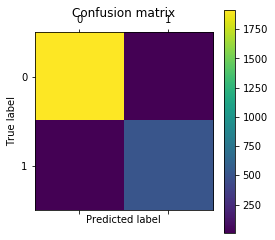

In [98]:
plt.matshow(cm)
plt.title('Confusion matrix')
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [99]:
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
print(roc_auc)

roc_auc = roc_auc_score(y_test, y_pred, average=None)
roc_auc

0.9899266074947126


0.9899266074947126

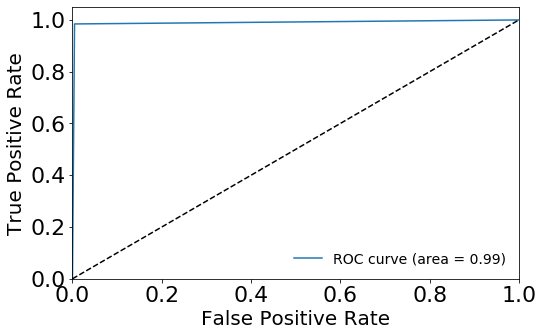

In [100]:
plt.figure(figsize=(8, 5))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % (roc_auc))
    
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=20)
plt.ylabel('True Positive Rate', fontsize=20) 
plt.tick_params(axis='both', which='major', labelsize=22)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.show()

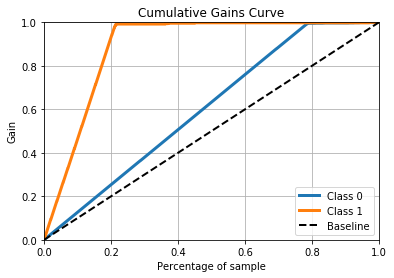

In [105]:
predicted_probas = Gclfestimator.predict_proba(X_test)
skplt.metrics.plot_cumulative_gain(y_test, predicted_probas)
plt.show()

In [109]:
predicted_probas

array([[1.        , 0.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       ...,
       [0.01245211, 0.98754789],
       [1.        , 0.        ],
       [1.        , 0.        ]])